# Ingestion & Cleaning — USA Salaries

In [1]:
##1.Setup and Ingestion 

In [2]:
# Import core data analysis libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 200)


In [3]:
# Statement 1: Variable assignment
RAW_PATH = Path('../Global-AI-Job-Market-Salary-Trends-Benchmarking-/data/ai_job_dataset0.csv')

# Statement 2: Conditional check
if not RAW_PATH.exists():
    raise FileNotFoundError(f"Place the dataset at {RAW_PATH} before running this notebook.")

# 1. Load the dataset
df = pd.read_csv(RAW_PATH, low_memory=False)
print(f"Dataset loaded successfully. Initial shape: {df.shape}")

# Initial check: display info and missing values
print("\nInitial DataFrame Info:")
df.info()


Dataset loaded successfully. Initial shape: (15000, 19)

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_id                  15000 non-null  object 
 1   job_title               15000 non-null  object 
 2   salary_usd              15000 non-null  int64  
 3   salary_currency         15000 non-null  object 
 4   experience_level        15000 non-null  object 
 5   employment_type         15000 non-null  object 
 6   company_location        15000 non-null  object 
 7   company_size            15000 non-null  object 
 8   employee_residence      15000 non-null  object 
 9   remote_ratio            15000 non-null  int64  
 10  required_skills         15000 non-null  object 
 11  education_required      15000 non-null  object 
 12  years_experience        15000 non-null  int64  
 13  industry  

### Quick schema check — align to proposal columns
We expect the dataset to contain (per proposal):
- job_id, job_title, salary_usd, salary_currency, salary_local, experience_level,
- employment_type, job_category, company_location, company_size, employee_residence,
- remote_ratio, required_skills, education_required, years_experience, industry,
- posting_date, application_deadline, job_description_length, benefits_score

We'll display the actual columns present and map / rename where needed.

In [4]:
#2. Column Normalization

In [5]:
def canonicalize_columns(df_in):
    """Lowercases and standardizes column names."""
    df_out = df_in.copy()
    col_map = {c: c.strip().lower().replace('-', '_').replace(' ', '_') for c in df_out.columns}
    df_out = df_out.rename(columns=col_map)
    return df_out

df_cleaned = canonicalize_columns(df)
print('Canonical columns:\n', df_cleaned.columns.tolist())


Canonical columns:
 ['job_id', 'job_title', 'salary_usd', 'salary_currency', 'experience_level', 'employment_type', 'company_location', 'company_size', 'employee_residence', 'remote_ratio', 'required_skills', 'education_required', 'years_experience', 'industry', 'posting_date', 'application_deadline', 'job_description_length', 'benefits_score', 'company_name']


In [6]:
#3. Dropping Unnecessary Columns

In [7]:
# Define columns to drop as per your focus
cols_to_drop = ['salary_local', 'salary_currency']

# Check for other potential columns to drop (e.g., if they are mostly empty)
# df_cleaned.isnull().sum() / len(df_cleaned) # <-- Run this to check % missing

# Perform the drop
existing_cols_to_drop = [col for col in cols_to_drop if col in df_cleaned.columns]
df_cleaned.drop(columns=existing_cols_to_drop, inplace=True)

print(f"Dropped columns: {existing_cols_to_drop}")
print(f"DataFrame shape after drops: {df_cleaned.shape}")


Dropped columns: ['salary_currency']
DataFrame shape after drops: (15000, 18)


In [8]:
#4. Handling Duplicates and Missing Salary

In [9]:
# Check for and remove duplicates based on the unique job identifier
initial_rows = df_cleaned.shape[0]
df_cleaned.drop_duplicates(subset=['job_id'], inplace=True, keep='first')
print(f"Duplicates removed. Rows remaining: {df_cleaned.shape[0]}")
print(f"Rows dropped: {initial_rows - df_cleaned.shape[0]}")

# Drop rows where the target variable (Salary_usd) is missing
# We cannot use these rows for salary analysis or modeling.
initial_salary_rows = df_cleaned.shape[0]
df_cleaned.dropna(subset=['salary_usd'], inplace=True)
print(f"Rows dropped due to missing Salary_usd: {initial_salary_rows - df_cleaned.shape[0]}")


Duplicates removed. Rows remaining: 15000
Rows dropped: 0
Rows dropped due to missing Salary_usd: 0


In [10]:
#5. Data Type Conversions

In [11]:
# Convert date columns
for dcol in ['posting_date', 'application_deadline']:
    if dcol in df_cleaned.columns:
        df_cleaned[dcol] = pd.to_datetime(df_cleaned[dcol], errors='coerce')

# Convert key numeric columns
for ncol in ['years_experience', 'job_description_length', 'benefits_score']:
     if ncol in df_cleaned.columns:
        df_cleaned[ncol] = pd.to_numeric(df_cleaned[ncol], errors='coerce')

print("Converted date and numeric columns.")
df_cleaned[['posting_date', 'years_experience', 'salary_usd']].info()


Converted date and numeric columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   posting_date      15000 non-null  datetime64[ns]
 1   years_experience  15000 non-null  int64         
 2   salary_usd        15000 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 351.7 KB


### Notes on salary fields
- `salary_usd` is our canonical target. If it's missing but `salary_local` + `salary_currency` exist, we could convert using an exchange rates CSV. For reproducibility we avoid live API calls. If you want conversions, add `data/lookup/exchange_rates.csv` with `currency_code,rate_to_usd`.

In [12]:
#6. Categorical Standardization

In [13]:
# Map acronyms to clear, full text
if 'experience_level' in df_cleaned.columns:
    exp_map = {'EN': 'Entry-Level', 'MI': 'Mid-Level', 'SE': 'Senior-Level', 'EX': 'Executive'}
    df_cleaned['experience_level'] = df_cleaned['experience_level'].map(exp_map).fillna(df_cleaned['experience_level'])

if 'company_size' in df_cleaned.columns:
    size_map = {'S': 'Small (<50)', 'M': 'Medium (50-250)', 'L': 'Large (>250)'}
    df_cleaned['company_size'] = df_cleaned['company_size'].map(size_map).fillna(df_cleaned['company_size'])

if 'employment_type' in df_cleaned.columns:
    emp_map = {'FT': 'Full-Time', 'PT': 'Part-Time', 'CT': 'Contract', 'FL': 'Freelance'}
    df_cleaned['employment_type'] = df_cleaned['employment_type'].map(emp_map).fillna(df_cleaned['employment_type'])

# Create remote_type from remote_ratio
def remote_type_from_ratio(x):
    if pd.isna(x): return 'Unknown'
    if x == 0: return 'Onsite'
    if x == 100: return 'Fully Remote'
    if 0 < x < 100: return 'Hybrid'
    return 'Unknown'

if 'remote_ratio' in df_cleaned.columns:
    df_cleaned['remote_type'] = df_cleaned['remote_ratio'].apply(remote_type_from_ratio)

print("Standardized 'experience_level', 'company_size', 'employment_type', and created 'remote_type'.")


Standardized 'experience_level', 'company_size', 'employment_type', and created 'remote_type'.


In [14]:
#7. Feature Engineering: Skills Count

In [15]:
import re

def parse_skills(text):
    if pd.isna(text):
        return []
    # Split on common delimiters: comma, semicolon, pipe, newline
    parts = re.split(r'[;,|\n]+', str(text))
    # Clean up whitespace, lowercase, and remove empty strings
    skills = [p.strip().lower() for p in parts if p.strip()]
    # Return unique skills
    return list(dict.fromkeys(skills)) # Fast way to get unique list preserving order

if 'required_skills' in df_cleaned.columns:
    df_cleaned['skills_list'] = df_cleaned['required_skills'].apply(parse_skills)
    df_cleaned['skills_count'] = df_cleaned['skills_list'].apply(len)
    print("Created 'skills_list' and 'skills_count' features.")
else:
    print("Warning: 'required_skills' column not found. Skipping skill processing.")

# Display sample of engineered features
print(df_cleaned[['required_skills', 'skills_list', 'skills_count']].head())


Created 'skills_list' and 'skills_count' features.
                                   required_skills  \
0         Tableau, PyTorch, Kubernetes, Linux, NLP   
1  Deep Learning, AWS, Mathematics, Python, Docker   
2     Kubernetes, Deep Learning, Java, Hadoop, NLP   
3                        Scala, SQL, Linux, Python   
4                     MLOps, Java, Tableau, Python   

                                         skills_list  skills_count  
0         [tableau, pytorch, kubernetes, linux, nlp]             5  
1  [deep learning, aws, mathematics, python, docker]             5  
2     [kubernetes, deep learning, java, hadoop, nlp]             5  
3                        [scala, sql, linux, python]             4  
4                     [mlops, java, tableau, python]             4  


In [16]:
#8. Numerical Imputation & Outlier Handling

In [17]:
# Impute 'years_experience' and 'benefits_score' with the median
for col in ['years_experience', 'benefits_score']:
    if col in df_cleaned.columns and df_cleaned[col].isnull().any():
        median_val = df_cleaned[col].median()
        df_cleaned[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in '{col}' with median: {median_val}")

# --- Outlier Handling (Salary_usd) ---
# We'll flag outliers and create a 'winsorized' (trimmed) column for modeling.
# This keeps the data points but caps them at a reasonable level.
Q1 = df_cleaned['salary_usd'].quantile(0.25)
Q3 = df_cleaned['salary_usd'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Ensure lower bound is not negative (salaries can't be negative)
lower_bound = max(0, lower_bound)

df_cleaned['salary_outlier'] = (~df_cleaned['salary_usd'].between(lower_bound, upper_bound))
df_cleaned['salary_usd_trimmed'] = df_cleaned['salary_usd'].clip(lower=lower_bound, upper=upper_bound)

print(f"\nSalary outliers flagged: {df_cleaned['salary_outlier'].sum()} rows.")
print("Created 'salary_usd_trimmed' for robust modeling.")
print(df_cleaned[['salary_usd', 'salary_usd_trimmed']].describe(percentiles=[.01, .25, .5, .75, .99]))



Salary outliers flagged: 483 rows.
Created 'salary_usd_trimmed' for robust modeling.
          salary_usd  salary_usd_trimmed
count   15000.000000        15000.000000
mean   115348.965133       114125.066192
std     60260.940438        56554.408273
min     32519.000000        32519.000000
1%      37268.670000        37268.670000
25%     70179.750000        70179.750000
50%     99705.000000        99705.000000
75%    146408.500000       146408.500000
99%    307775.690000       260751.625000
max    399095.000000       260751.625000


In [18]:
#9. Save Cleaned Data

In [19]:
OUT_DIR = Path('data/processed')
OUT_DIR.mkdir(parents=True, exist_ok=True)
clean_path = OUT_DIR / 'cleaned_jobs_global.csv'

df_cleaned.to_csv(clean_path, index=False)

print(f"Saved cleaned global data to: {clean_path}")
print(f"Final dataset shape: {df_cleaned.shape}")

# Generate a simple cleaning report
report = {
    'generated_at': pd.Timestamp.now().isoformat(),
    'rows_input': int(df.shape[0]),
    'rows_after_duplicates': int(initial_rows - (initial_rows - df_cleaned.shape[0])),
    'rows_after_missing_salary_drop': int(df_cleaned.shape[0]),
    'salary_outliers_flagged': int(df_cleaned['salary_outlier'].sum()),
    'output_file': str(clean_path)
}
import json
with open(OUT_DIR / 'cleaning_report_global.json', 'w') as f:
    json.dump(report, f, indent=2)

print(f"Cleaning report written to: {OUT_DIR / 'cleaning_report_global.json'}")


Saved cleaned global data to: data\processed\cleaned_jobs_global.csv
Final dataset shape: (15000, 23)
Cleaning report written to: data\processed\cleaning_report_global.json


In [20]:
#10. Initial Feature Importance Matrix

Numeric features for model: ['skills_count', 'years_experience', 'benefits_score', 'job_description_length', 'remote_ratio']
Categorical features for model: ['experience_level', 'company_size', 'remote_type', 'employment_type', 'education_required', 'industry', 'company_location', 'employee_residence']
Feature matrix shape: (15000, 78)
Training RandomForest model...
Saved importance matrix to: data\processed\feature_importance_global.csv


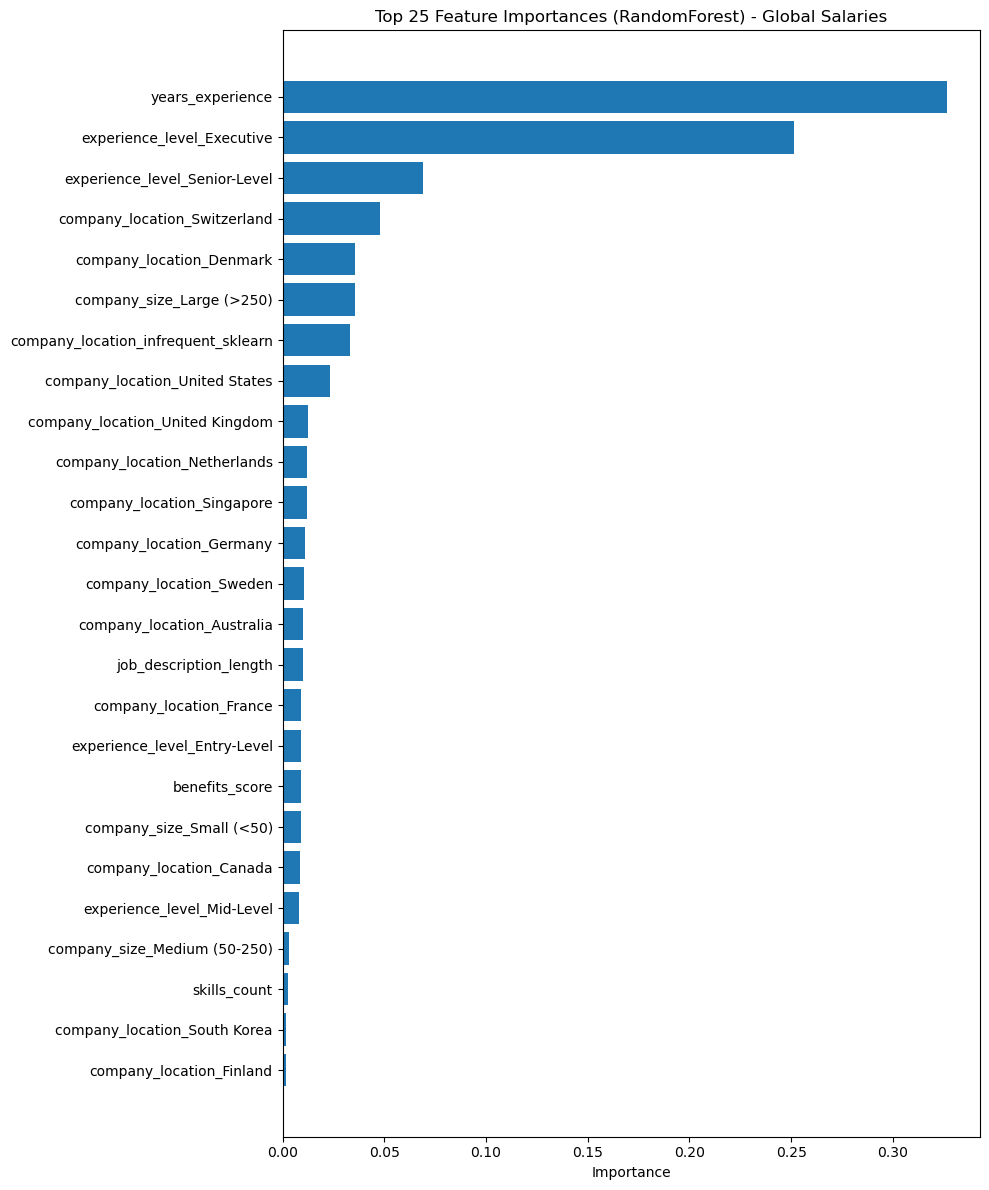


--- Ingestion, Cleaning, and Importance Matrix Complete ---


In [21]:
# Define feature columns for the model
# Now we include 'company_location' and 'employee_residence' as they are key global factors
feat_cols_num = ['skills_count', 'years_experience', 'benefits_score', 'job_description_length', 'remote_ratio']
feat_cols_cat = ['experience_level', 'company_size', 'remote_type', 'employment_type', 
                 'education_required', 'job_category', 'industry', 
                 'company_location', 'employee_residence'] # Added location columns

# Filter to columns that actually exist in the dataframe
feat_cols_num = [c for c in feat_cols_num if c in df_cleaned.columns]
feat_cols_cat = [c for c in feat_cols_cat if c in df_cleaned.columns]

print(f"Numeric features for model: {feat_cols_num}")
print(f"Categorical features for model: {feat_cols_cat}")

# --- Prepare data for modeling ---
model_df = df_cleaned.copy()
# Ensure target variable has no NaNs
model_df.dropna(subset=['salary_usd_trimmed'], inplace=True)

X_num = model_df[feat_cols_num].copy()

# --- THIS IS THE FIXED LINE ---
# One-Hot Encode categorical features
# We fill NaNs with 'Unknown' and limit to top 20 categories per feature
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=20)
# -----------------------------

X_cat_raw = model_df[feat_cols_cat].fillna('Unknown').astype(str)
X_cat = ohe.fit_transform(X_cat_raw)
ohe_cols = ohe.get_feature_names_out(feat_cols_cat)
X_cat_df = pd.DataFrame(X_cat, columns=ohe_cols, index=model_df.index)

# Combine numeric and categorical features
X = pd.concat([X_num, X_cat_df], axis=1)
y = model_df['salary_usd_trimmed'] # Use the trimmed salary for robust modeling

# Ensure X and y have the same index (in case dropping NaNs in y removed rows)
X = X.loc[y.index]

print(f"Feature matrix shape: {X.shape}")

# --- Train/test split and RandomForest ---
if X.shape[1] > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Using a simple, fast model
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15)
    print("Training RandomForest model...")
    rf.fit(X_train, y_train)
    
    # Get importances
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    importance_df = importances[importances > 0.001].reset_index() # Filter weak importances
    importance_df.columns = ['feature', 'importance']
    
    # Save importance CSV
    importance_path = OUT_DIR / 'feature_importance_global.csv'
    importance_df.to_csv(importance_path, index=False)
    print(f"Saved importance matrix to: {importance_path}")

    # --- Plot Top 25 Features ---
    plt.figure(figsize=(10, 12))
    top_n = importance_df.head(25).sort_values('importance')
    plt.barh(top_n['feature'], top_n['importance'])
    plt.title('Top 25 Feature Importances (RandomForest) - Global Salaries')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
else:
    print("No features available for importance calculation. Check columns and rerun.")

print("\n--- Ingestion, Cleaning, and Importance Matrix Complete ---")

## Next steps & notes
- Review `data/processed/cleaned_jobs_usa.parquet` and `data/processed/feature_importance.csv`.

